# Data Processing & Normalization Evaluation

This notebook evaluates the performance and quality of the text normalization and tokenization steps, which are critical for Tier 1 detection.

In [16]:
import sys
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import importlib

# Add parent directory to path to import app modules
sys.path.append(os.path.abspath(".."))

from app.features import normalization
# Reload to get latest changes
importlib.reload(normalization)
from app.features.normalization import normalize_code_ast, tokenize_source

## 1. Load Dataset
Loading a sample from BigCloneBench or using mock data.

In [17]:
# Try loading local parquet if exists, else mock
parquet_path = "../datasets/raw/bigclonebench_400k.parquet"
try:
    df = pd.read_parquet(parquet_path).head(1000)
    print(f"Loaded {len(df)} samples from {parquet_path}")
    # Handle different column naming conventions
    if 'code' not in df.columns:
        if 'func_code' in df.columns:
            df['code'] = df['func_code']
        elif 'code_1' in df.columns:
            # For clone detection datasets, use code_1 as the primary code
            df['code'] = df['code_1']
except FileNotFoundError:
    print("Dataset not found. Using mock data.")
    data = [
        {"id": "1", "code": "public void test() { int a = 10; System.out.println(a); }"},
        {"id": "2", "code": "public void test2() { int b = 20; System.out.println(b); }"},
        {"id": "3", "code": "// Comment\npublic int add(int x, int y) { return x + y; }"}
    ]
    df = pd.DataFrame(data)

print(df.head())

Loaded 1000 samples from ../datasets/raw/bigclonebench_400k.parquet
                                     id  \
0  2bb79f6f-765e-44e4-8cfd-19c03c00f8df   
1  beaed64a-2b9a-48e3-9f9a-2b68b40330d2   
2  af382169-dcf2-48f7-9dab-0ef6be0449ae   
3  07d1ac67-10e0-4acf-9a64-688097fdb226   
4  16ef572d-6a43-449a-b665-90480d51c795   

                                              code_1  \
0  static void copy(String src, String dest) thro...   
1  public void convert(File src, File dest) throw...   
2  public void convert(File src, File dest) throw...   
3  public static void main(String[] args) {\n    ...   
4  protected void doGet(HttpServletRequest reques...   

                                              code_2 clone_type  \
0  static void copy(String src, String dest) thro...          1   
1  public void convert(File src, File dest) throw...          1   
2  ResultSet rs = null;\n        Local local = nu...          1   
3  public static void main(String[] args) {\n    ...          1   
4

## 2. Normalization Performance
Measuring the time taken to normalize code and the reduction in vocabulary size.

In [18]:
start_time = time.time()

df['normalized_code'] = df['code'].apply(normalize_code_ast)

end_time = time.time()
print(f"Normalization Time for {len(df)} items: {end_time - start_time:.4f} seconds")
print(f"Average per item: {(end_time - start_time)/len(df):.4f} seconds")

Normalization Time for 1000 items: 2.1594 seconds
Average per item: 0.0022 seconds


### Example Normalization

In [19]:
print("Original:")
print(df.iloc[0]['code'])
print("\nNormalized:")
print(df.iloc[0]['normalized_code'])

Original:
static void copy(String src, String dest) throws IOException {
        File ifp = new File(src);
        File ofp = new File(dest);
        if (ifp.exists() == false) {
            throw new IOException("file '" + src + "' does not exist");
        }
        FileInputStream fis = new FileInputStream(ifp);
        FileOutputStream fos = new FileOutputStream(ofp);
        byte[] b = new byte[1024];
        int readBytes;
        while ((readBytes = fis.read(b)) > 0) fos.write(b, 0, readBytes);
        fis.close();
        fos.close();
    }

Normalized:
static void VAR(String VAR, String VAR) throws IOException { File VAR = new File(VAR); File VAR = new File(VAR); if (VAR.VAR() == false) { throw new IOException(LIT + VAR + LIT); } FileInputStream VAR = new FileInputStream(VAR); FileOutputStream VAR = new FileOutputStream(VAR); byte[] VAR = new byte[LIT]; int VAR; while ((VAR = VAR.VAR(VAR)) > LIT) VAR.VAR(VAR, LIT, VAR); VAR.VAR(); VAR.VAR(); }


## 3. Tokenization Statistics

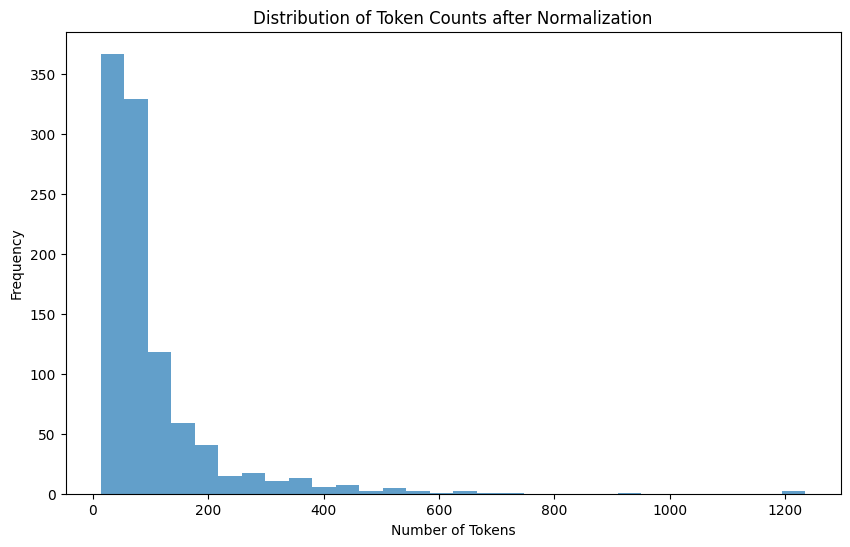

In [20]:
df['tokens'] = df['normalized_code'].apply(tokenize_source)
df['num_tokens'] = df['tokens'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['num_tokens'], bins=30, alpha=0.7)
plt.title('Distribution of Token Counts after Normalization')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()